In [1]:
#pip install faiss-cpu

In [2]:
#pip install feature_engine

# Поиск наиболее похожего товара по набору признаков

В этом проекте мы решаем задачу метчинга товаров. Мы хотим разработать модель, которая рекомендовала бы пользователю маркетплейса наиболее похожий товар на тот, который он просматривает. У нас есть база данных со всеми товарами (base) и выборка train где каждому товару соответствует один наиболее подходящий товар из base. Попробуем сначала найти для каждого товара набор ближайших соседей с помощью библиотеки Faiss, а затем отранжировать получившийся набор по степени похожести с помощью классификации. Целевой метрикой сделаем accuracy@5 - т.е. в какой доле случаев один из 5 товаров, которые получим в результате ранжирования, окажется наиболее похожим. 

In [3]:
import faiss
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import Normalizer, QuantileTransformer


from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from catboost import CatBoostClassifier

Загружаем данные и смотрим на их формат

In [46]:
base = pd.read_csv('./base.csv', index_col=0)
train = pd.read_csv('./train.csv', index_col=0)
validation = pd.read_csv('./validation.csv', index_col=0)
validation_answer = pd.read_csv('./validation_answer.csv')
base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [5]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [6]:
base.shape

(2918139, 72)

In [7]:
train.shape

(100000, 73)

In [8]:
validation.shape

(100000, 72)

In [9]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


Пропусков в данных нет. Посмотрим на распределения значений в разных полях датасета base

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>],
       [<AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>,
        <AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'11'}>,
        <AxesSubplot:title={'center':'12'}>,
        <AxesSubplot:title={'center':'13'}>,
        <AxesSubplot:title={'center':'14'}>,
        <AxesSubplot:title={'center':'15'}>],
       [<AxesSubplot:title={'center':'16'}>,
        <AxesSubplot:title={'center':'17'}>,
        <AxesSubplot:title={'center':'18'}>,
        <AxesSubplot:title={'center':'19'}>,
        <AxesSubplot:title={'center':'20'}>,
        <AxesSubplot:title={'center':'21'}>,
        <AxesSubpl

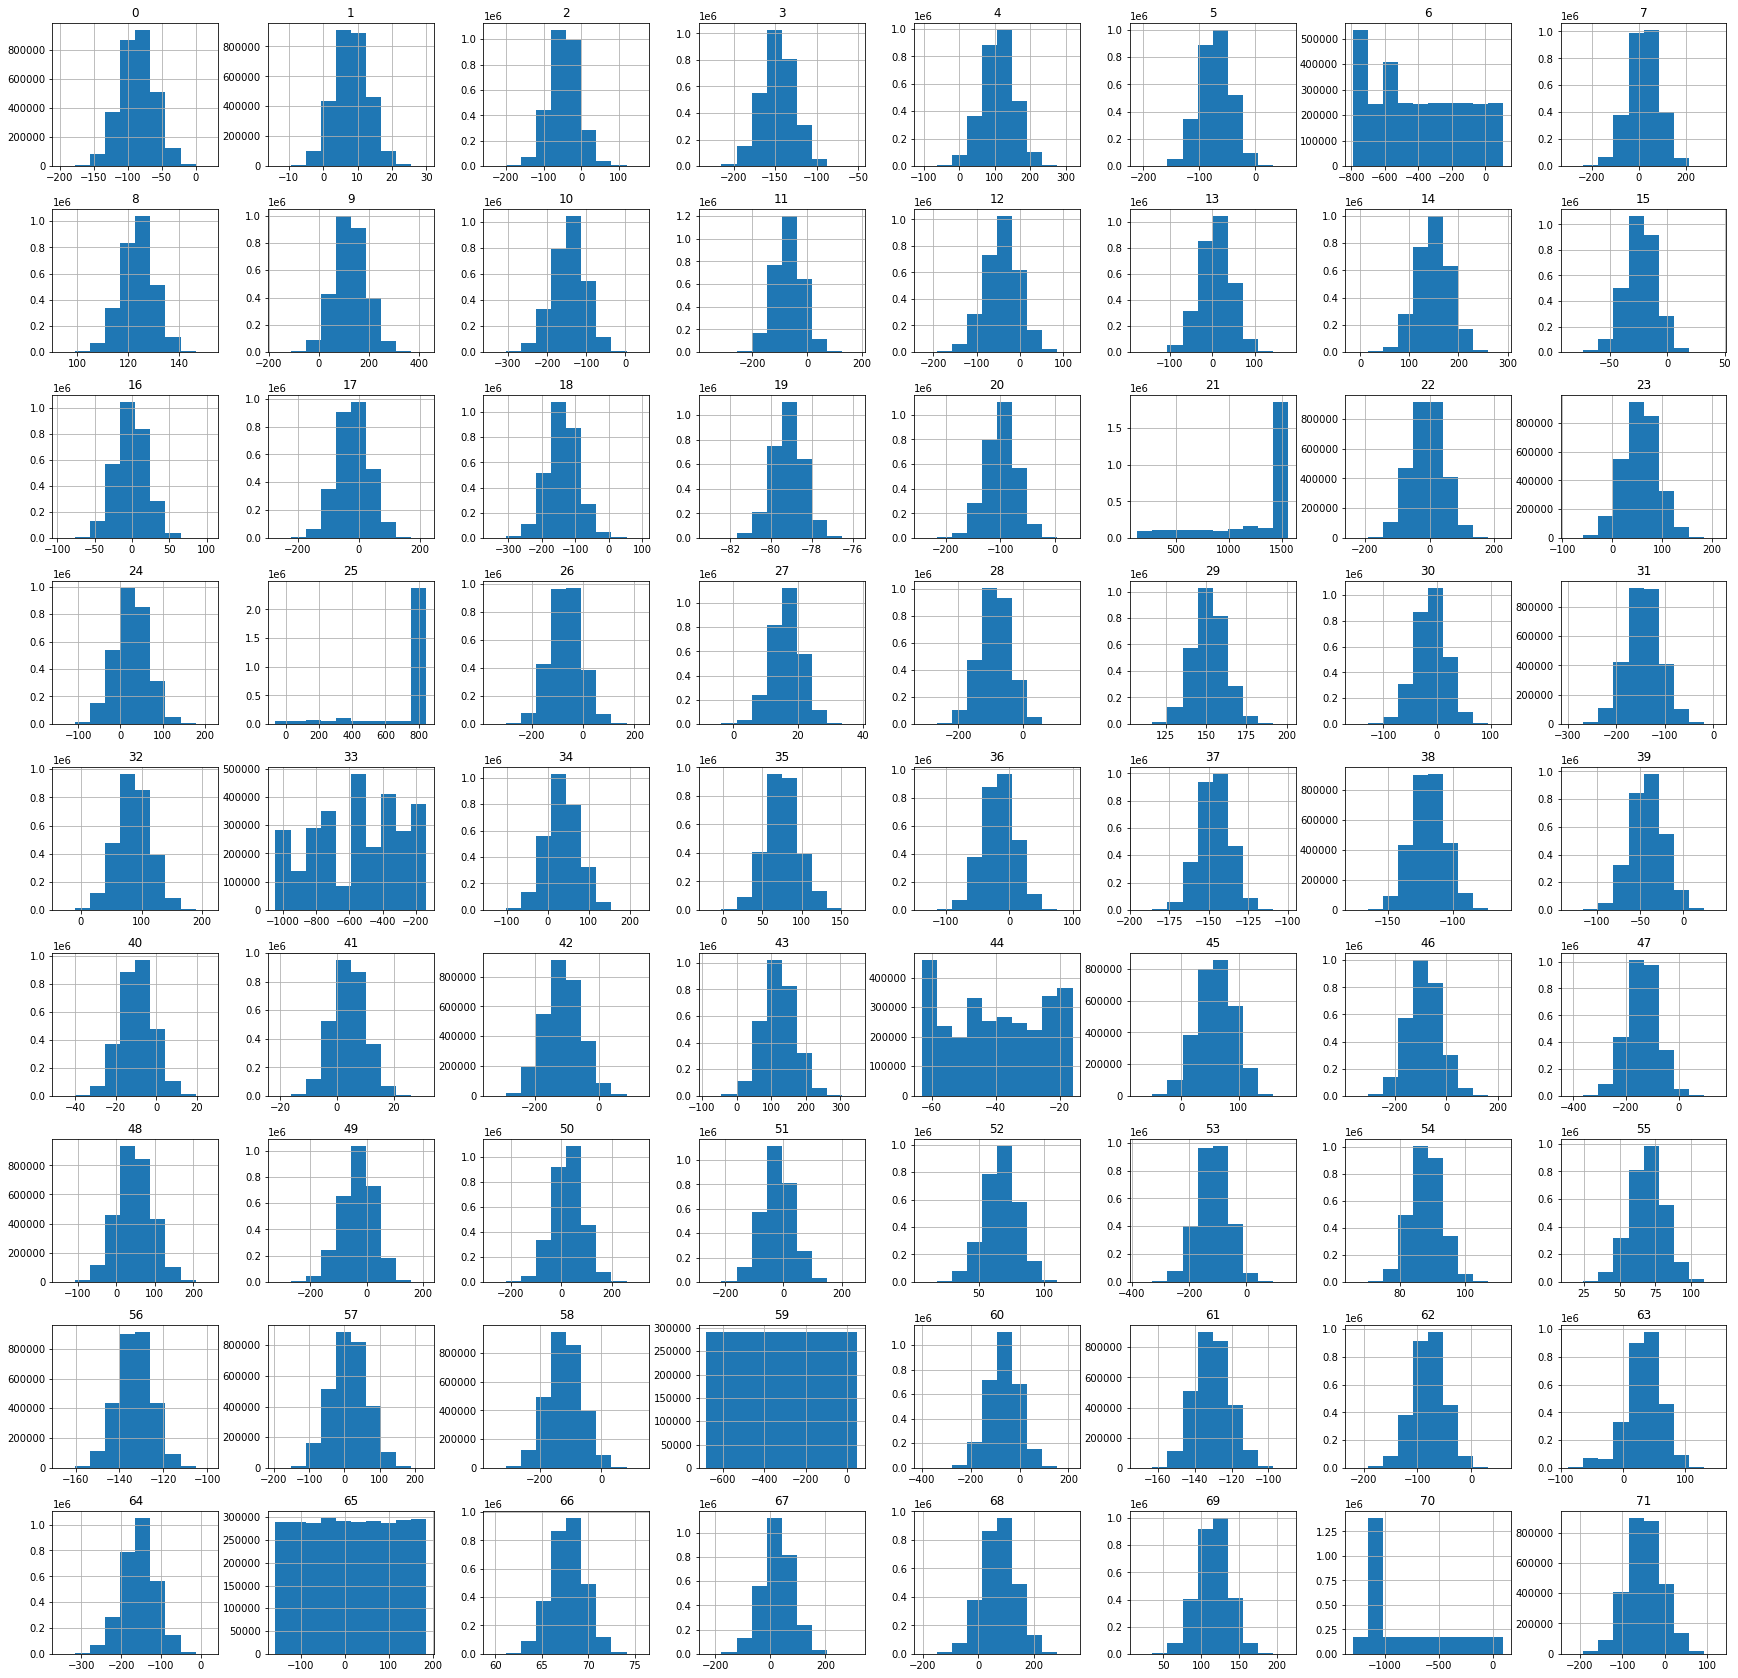

In [10]:
base.hist(figsize=(30, 30))

Распределение некоторых полей далеко от нормального. Если удалить их из датасета, метрика немного возрастает. Чтрбы встроить удаление полей в Pipeline создадим функцию и класс

In [11]:
def delete_features(df):
    df_ = df.drop(['6','21','25','59','65','70'], axis = 1)
    return df_

In [12]:
class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        print('')

    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X_ = delete_features(X)
        return X_ 

In [13]:
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=1234)


Записываем все преобразования данных в пайплайн и применяем его к base

In [14]:
pipeline = Pipeline([
    ('preprocessing', Preprocessing()),
    ('scale', StandardScaler()),
    ('normalize', Normalizer()),
    ('quantilize', quantile_transformer)
])

In [15]:
base_transformed = pipeline.fit_transform(base)

Указываем параметры для Faiss

In [16]:
dims = base_transformed.shape[1]

n_cells = 70


quantizer = faiss.IndexFlatL2(dims) 

index = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_L2)


Создаем словарь соответствий числовых и строковых индексов, чтобы потом использовать его в джойнах таблиц

In [17]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}
train_index = {v: k for k, v in enumerate(train.index.to_list())}
valid_index = {v: k for k, v in enumerate(validation.index.to_list())}

In [18]:
index.train(np.ascontiguousarray(base_transformed))  # train on the database vectors

index.add(np.ascontiguousarray(base_transformed))   # add the vectors and update the index

Для обучающей выборки товаров находим по 80 соседей и смотрим в какой доле случаев товар попал в эти 80

In [19]:
targets = train["Target"]
train.drop("Target", axis=1, inplace=True)


In [20]:
train_transformed = pipeline.transform(train)

In [21]:
r, idx = index.search(np.ascontiguousarray(train_transformed).astype('float32'), 80)

In [22]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(acc / len(idx))

0.66565


Получаем результат 66,5%

Теперь нам нужно создать таблицу, которая включала бы все признаки товара из выборки train, все признаки ближайших соседей соответствующего товара и целевой признак - является ли выбранный сосед рекомендованным экспертами. Для этих преобразований создадим функцию

In [23]:
def make_dataframe(base, base_index, idx, targets, train, train_index):
    idx_df = pd.DataFrame(index = targets.index, data = idx)
    idx_cols = idx_df.columns
    idx_df.reset_index(inplace = True)
#Делаем таблицу формата id запроса (query id) - индекс соседа
    idx_df_flat = pd.melt(idx_df, id_vars=['Id'], value_vars=idx_cols)
    idx_df_flat.drop(columns = ['variable'], inplace = True)
#превращаем np.array обратно в df
    base = pd.DataFrame(index = base_index, columns = [str(i) for i in range(66)], data = base)
    train = pd.DataFrame(index = list(train_index.values()), columns = [str(i) for i in range(66)], data = train)
#Присоединяем все признаки найденных соседей
    idx_x_base = idx_df_flat.merge(base, left_on = 'value', right_index = True)
#Джойним индекс рекомендованного товара
    idx_base_target = idx_x_base.merge(targets, left_on = 'Id', right_index = True)
    idx_base_target['value'] = idx_base_target['value'].apply(lambda x: base_index[x])
    idx_base_target['target_new'] = 0
#Проставляем целевой признак
    idx_base_target.loc[idx_base_target['value'] == idx_base_target['Target'], 'target_new'] = 1
    idx_base_target['Id'] = idx_base_target['Id'].apply(lambda x: train_index[x])
    idx_base_target.drop(columns = ['value','Target'], inplace = True)
#Собираем финальную таблицу   
    new_df = train.merge(idx_base_target, left_index = True, right_on = 'Id')
    return new_df

In [24]:
new_df = make_dataframe(base_transformed, base_index, idx, targets,  train_transformed, train_index)

In [25]:
pd.set_option('display.max_seq_items', 150)

In [26]:
new_df.memory_usage().sum()

8640000000

Выделяем features и target

In [27]:
X = new_df.drop(['target_new', 'Id'], axis = 1)
y = new_df['target_new']

In [28]:
#Initialize CatBoostClassifier
#model = CatBoostClassifier(eval_metric='AUC',
#                            iterations=100,
#                           learning_rate=0.1,
#                           depth=10)
                         

In [29]:
#X_train, X_test, y_train, y_test = X.iloc[:5250000], X.iloc[5250000:], y.iloc[:5250000], y.iloc[5250000:]

In [30]:
#model.fit(X_train, y_train,
#         eval_set=(X_test, y_test),
#          verbose=True
#)

Подбираем гиперпараметры

In [31]:
#model = CatBoostClassifier(eval_metric='AUC')
#grid_search_res = model.grid_search({'iterations': [150],
#              'learning_rate': [0.1, 0.5, 1],
#              'l2_leaf_reg' : [5,7],
#              'depth': [10],
#              'verbose':[100]
#             }
#,
#            X,
#            y,
#            cv=3,
#            partition_random_seed=42,
#            calc_cv_statistics=True,
#            search_by_train_test_split=True,
#            refit=True,
#            shuffle=True,
#            stratified=None,
#            train_size=0.8,
#            verbose=True,
#            plot=False,
#)
#
#print(grid_search_res)

In [32]:
#grid_search_res['params']

Модель с подобранными гиперпараметрами обучаем на полных данных выборки train

In [33]:
best_model = CatBoostClassifier(
    eval_metric='AUC',
    iterations=150,
    learning_rate=0.5,
    depth=10,
    l2_leaf_reg = 5
)
                         

In [34]:
best_model.fit(X, y)

0:	total: 3.39s	remaining: 8m 25s
1:	total: 6.63s	remaining: 8m 10s
2:	total: 9.71s	remaining: 7m 55s
3:	total: 12.6s	remaining: 7m 38s
4:	total: 15.6s	remaining: 7m 31s
5:	total: 18.7s	remaining: 7m 28s
6:	total: 21.7s	remaining: 7m 23s
7:	total: 24.9s	remaining: 7m 21s
8:	total: 28s	remaining: 7m 18s
9:	total: 31.2s	remaining: 7m 16s
10:	total: 34.2s	remaining: 7m 12s
11:	total: 37.4s	remaining: 7m 9s
12:	total: 40.5s	remaining: 7m 7s
13:	total: 43.4s	remaining: 7m 2s
14:	total: 46.6s	remaining: 6m 58s
15:	total: 49.6s	remaining: 6m 55s
16:	total: 52.8s	remaining: 6m 53s
17:	total: 55.9s	remaining: 6m 49s
18:	total: 59.3s	remaining: 6m 48s
19:	total: 1m 2s	remaining: 6m 46s
20:	total: 1m 5s	remaining: 6m 43s
21:	total: 1m 8s	remaining: 6m 40s
22:	total: 1m 11s	remaining: 6m 37s
23:	total: 1m 15s	remaining: 6m 34s
24:	total: 1m 18s	remaining: 6m 31s
25:	total: 1m 21s	remaining: 6m 28s
26:	total: 1m 24s	remaining: 6m 25s
27:	total: 1m 27s	remaining: 6m 22s
28:	total: 1m 30s	remaining: 

In [35]:
#probabilities_one = model.predict_proba(X_test)[:,1]
#y_test_compare = y_test.copy().to_frame()
#id_map = new_df['Id'].to_frame()
#y_test_compare = y_test_compare.merge(id_map, left_index = True, right_index = True)
#y_test_compare['predicted'] = probabilities_one
#N = 5
#msk = y_test_compare.groupby('Id')['predicted'].rank(method='first', ascending=False) <= N
#df_filtered = y_test_compare.loc[msk, :]
#df_filtered['target_new'].sum()/df_filtered['Id'].unique().shape[0]

## Проверим на тестовых данных

In [36]:
validation.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [37]:
validation_answer.head()

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


Приводим validation_answer к формату, который соответствует таблице Targets, которую использовали для обучающей выборки

In [38]:
validation_answer = validation_answer.set_index('Id')
validation_answer = validation_answer['Expected']
validation_answer.name = 'Target'

Применяем преобразования

In [39]:
validation_transformed = pipeline.transform(validation)

Ищем по 80 соседей

In [41]:
r_t, idx_t = index.search(np.ascontiguousarray(validation_transformed).astype('float32'), 70)

In [42]:
acc = 0
for target, el in zip(validation_answer.tolist(), idx_t.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(acc / len(idx_t))

0.66036


Faiss дает результат 66 процентов. Близко к тому, что получали на обучающей выборке.

Теперь создадим таблицу, которую будем использовать для задачи классификации

In [43]:
new_df_t = make_dataframe(base_transformed, base_index, idx_t, validation_answer, validation_transformed, valid_index)

In [44]:
X_t = new_df_t.drop(['target_new', 'Id'], axis = 1)
y_t = new_df_t['target_new']

Для подсчета accuracy@5 для каждого запроса возьмем 5 соседей, для которых по результатам предсказаний максимальна вероятность, что целевой признак равен 1. И проверим в какой доле случаев верный по мнению экспертов ответ попал в число этих пяти

In [45]:
probabilities_one = best_model.predict_proba(X_t)[:,1]
y_test_compare = y_t.copy().to_frame()
id_map = new_df['Id'].to_frame()
y_test_compare = y_test_compare.merge(id_map, left_index = True, right_index = True)
y_test_compare['predicted'] = probabilities_one
N = 5
msk = y_test_compare.groupby('Id')['predicted'].rank(method='first', ascending=False) <= N
df_filtered = y_test_compare.loc[msk, :]
df_filtered['target_new'].sum()/df_filtered['Id'].unique().shape[0]

0.59313

Получаем результат 59,3 %